# Qrylov

## Setup

In [1]:
from typing import List, Tuple

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})
import numpy as np
import scipy as sp

import openfermion as of
from openfermionpyscf import run_pyscf

import numpy as np
import openfermion as of

import cirq
import qiskit
import qiskit.qasm2
import quimb.tensor as qtn

from tensor_network_common import pauli_sum_to_mpo

## Parameters

In [2]:
# Problem to use.
problem: str = "hchain"  # Options: "hchain", "hubbard"

# For Hubbard Hamiltonian.
xdim: int = 2
ydim: int = 3

# For Hydrogen chains.
natoms: int = 6  # Number of H atoms in the (linear) chain.

hamiltonian_threshold: float = 0.02 # Drop terms in the Hamiltonian with coefficients smaller than this threshold.

# Initial state parameters.
seed: int = 1
alpha: float = 10.0  # The initial state is |ground state> + |random state> / alpha.

# Krylov parameters.
subspace_dimension: int = 16  # The dimension of the Krylov subspace.
threshold: float = -np.inf  # 1e-4  # -np.inf  # -1e-4  # Set to -np.inf to disable thresholding.

# Simulation parameters.
max_mpo_bond: int = 128  # Maximum bond dimension for MPO's.
max_mps_bond: int = 256  # Maximum bond dimension for MPS's.

In [3]:
def fill_h_and_s_matrices(
    vectors: List[np.ndarray] | List[np.ndarray],
    mpo: qtn.MatrixProductOperator | np.ndarray,
    verbose: bool = False,
) -> Tuple[np.ndarray, np.ndarray]:
    tensor_algebra = isinstance(mpo, qtn.MatrixProductOperator)

    dim = len(vectors)
    h = np.zeros((dim, dim), dtype=np.complex128)
    s = np.zeros((dim, dim), dtype=np.complex128)

    for i in range(dim):
        for j in range(i, dim):
            if verbose:
                print(f"A_{i}{j}", end=" ")

            if tensor_algebra:
                hij = vectors[i].H @ mpo.apply(vectors[j])
            else:
                hij = vectors[i].conj().T @ mpo @ vectors[j]

            h[i, j] = hij
            if i != j:
                h[j, i] = np.conjugate(hij)

            if tensor_algebra:
                sij = vectors[i].H @ vectors[j]
            else:
                sij = vectors[i].conj().T @ vectors[j]
            s[i, j] = sij
            if i != j:
                s[j, i] = np.conjugate(sij)
    return h, s


# Based on https://quantum.cloud.ibm.com/docs/en/tutorials/krylov-quantum-diagonalization.
# and Algorithm 1.1 of https://arxiv.org/abs/2110.07492.
def solve_regularized_gen_eig(
    h: np.ndarray,
    s: np.ndarray,
    threshold: float = -np.inf,
) -> float:
    s_vals, s_vecs = sp.linalg.eigh(s)
    s_vecs = s_vecs.T
    good_vecs = np.array(
        [vec for val, vec in zip(s_vals, s_vecs) if val > threshold]
    )
    h_reg = good_vecs.conj() @ h @ good_vecs.T
    s_reg = good_vecs.conj() @ s @ good_vecs.T
    return sp.linalg.eigh(h_reg, s_reg)[0][0]

## Problem definition

In [4]:
if problem == "hchain":
    bond_distance = 1.0
    geometry = [("H", (0, 0, i * bond_distance)) for i in range(natoms)]
    molecule = of.MolecularData(geometry, basis="sto-3g", multiplicity=1, charge=natoms % 2)

    molecule = run_pyscf(molecule, run_scf=True, run_mp2=True, verbose=True)

    hamiltonian = of.get_fermion_operator(molecule.get_molecular_hamiltonian())
    hamiltonian = of.jordan_wigner(hamiltonian)

elif problem == "hubbard":
    hamiltonian = of.jordan_wigner(
        of.hamiltonians.fermi_hubbard(
            xdim,
            ydim,
            1.0,
            1.0,
            spinless=True
        )
    )

else:
    raise ValueError(f"Unknown problem {problem}.")

Hartree-Fock energy for H6_sto-3g_singlet (6 electrons) is -3.1355322139663215.
MP2 energy for H6_sto-3g_singlet (6 electrons) is -3.1981379846242963.


In [6]:
if hamiltonian_threshold is not None:
    hamiltonian.compress(hamiltonian_threshold)

In [7]:
nqubits = of.utils.count_qubits(hamiltonian)
nterms = len(hamiltonian.terms)
print(f"Hamiltonian acts on {nqubits} qubit(s) and has {nterms} Pauli terms.")

Hamiltonian acts on 12 qubit(s) and has 275 Pauli terms.


## Exact energy

In [8]:
hamiltonian_cirq = of.qubit_operator_to_pauli_sum(hamiltonian)
mpo = pauli_sum_to_mpo(hamiltonian_cirq, cirq.LineQubit.range(nqubits), max_bond=max_mpo_bond, verbose=True)
mpo.show()

│4│12│23│30│36│50│38│34│29│16│4│
●─<──<──<──<──<──<──<──<──<──<─<
│ │  │  │  │  │  │  │  │  │  │ │


In [9]:
dmrg = qtn.DMRG2(mpo, bond_dims=[2 ** (i + 1) for i in range(int(np.log2(max_mpo_bond)))])
dmrg.solve(verbosity=1)

energy_exact = np.real(dmrg.energy)
ground_state = dmrg.state
print("Exact energy:", energy_exact)
ground_state.show()

1, R, max_bond=(2/2), cutoff:1e-08


100%|##########################################| 11/11 [00:00<00:00, 338.05it/s]

Energy: (-2.3795044924680675+9.796850830579018e-15j) ... not converged.
2, R, max_bond=(2/4), cutoff:1e-08



100%|##########################################| 11/11 [00:00<00:00, 319.85it/s]

Energy: (-3.158922043394147+8.34195993532072e-15j) ... not converged.
3, R, max_bond=(4/8), cutoff:1e-08



100%|##########################################| 11/11 [00:00<00:00, 259.38it/s]

Energy: (-3.1790639162420953+7.195795608677669e-15j) ... not converged.
4, R, max_bond=(8/16), cutoff:1e-08



100%|##########################################| 11/11 [00:00<00:00, 132.74it/s]

Energy: (-3.190027793444323+5.1445393084437185e-15j) ... not converged.
5, R, max_bond=(16/32), cutoff:1e-08



100%|###########################################| 11/11 [00:00<00:00, 18.94it/s]

Energy: (-3.191754376086811+5.648259637780484e-15j) ... not converged.
6, R, max_bond=(26/64), cutoff:1e-08



100%|###########################################| 11/11 [00:00<00:00, 11.23it/s]

Energy: (-3.1918352165972306+4.977789014315448e-15j) ... converged!
Exact energy: -3.1918352165972306
 2 4 8 15 25 38 28 16 8 4 2 
>─>─>─>──>──>──>──>──>─>─>─●
│ │ │ │  │  │  │  │  │ │ │ │


## Initial state

In [10]:
bvec = ground_state + qtn.MPS_rand_state(mpo.L, bond_dim=2, seed=seed) / alpha
bvec /= bvec.norm()
overlap = np.abs(bvec @ ground_state) ** 2
overlap

0.9901100146782349

## Krylov with $H$

In [11]:
vectors = [bvec]
for i in range(subspace_dimension - 1):
    print(i)
    new = mpo.apply(vectors[-1], compress=True, max_bond=max_mps_bond)
    print("Max bond:", new.max_bond())
    vectors.append(new)

0
Max bond: 62
1
Max bond: 62
2
Max bond: 62
3
Max bond: 61
4
Max bond: 60
5
Max bond: 60
6
Max bond: 60
7
Max bond: 60
8
Max bond: 60
9
Max bond: 60
10
Max bond: 60
11
Max bond: 60
12
Max bond: 60
13
Max bond: 61
14
Max bond: 61


In [12]:
h, s = fill_h_and_s_matrices(vectors, mpo, verbose=True)

A_00 A_01 A_02 A_03 A_04 A_05 A_06 A_07 A_08 A_09 A_010 A_011 A_012 A_013 A_014 A_015 A_11 A_12 A_13 A_14 A_15 A_16 A_17 A_18 A_19 A_110 A_111 A_112 A_113 A_114 A_115 A_22 A_23 A_24 A_25 A_26 A_27 A_28 A_29 A_210 A_211 A_212 A_213 A_214 A_215 A_33 A_34 A_35 A_36 A_37 A_38 A_39 A_310 A_311 A_312 A_313 A_314 A_315 A_44 A_45 A_46 A_47 A_48 A_49 A_410 A_411 A_412 A_413 A_414 A_415 A_55 A_56 A_57 A_58 A_59 A_510 A_511 A_512 A_513 A_514 A_515 A_66 A_67 A_68 A_69 A_610 A_611 A_612 A_613 A_614 A_615 A_77 A_78 A_79 A_710 A_711 A_712 A_713 A_714 A_715 A_88 A_89 A_810 A_811 A_812 A_813 A_814 A_815 A_99 A_910 A_911 A_912 A_913 A_914 A_915 A_1010 A_1011 A_1012 A_1013 A_1014 A_1015 A_1111 A_1112 A_1113 A_1114 A_1115 A_1212 A_1213 A_1214 A_1215 A_1313 A_1314 A_1315 A_1414 A_1415 A_1515 

In [13]:
krylov_dvals = []
krylov_evals = []
for d in range(1, len(h) + 1):
    try:
        krylov_energy = solve_regularized_gen_eig(h[:d, :d], s[:d, :d], threshold=threshold)
        print(d, krylov_energy)
        krylov_dvals.append(d)
        krylov_evals.append(krylov_energy)
    except np.linalg.LinAlgError:
        continue

1 -3.1620457703303297
2 -3.189796513303919
3 -3.191564260621541
4 -3.1917873018795264
5 -3.1918334294220427
6 -3.1918452409625164
7 -3.191848496148691
8 -3.1918495466079415
9 -3.1918499095814994
10 -3.1918500743288867
11 -3.1918501688857392
12 -3.1918502238688427
13 -3.1918502498719983
14 -3.191850260594055
15 -3.191850264031197
16 -3.1918502653633936


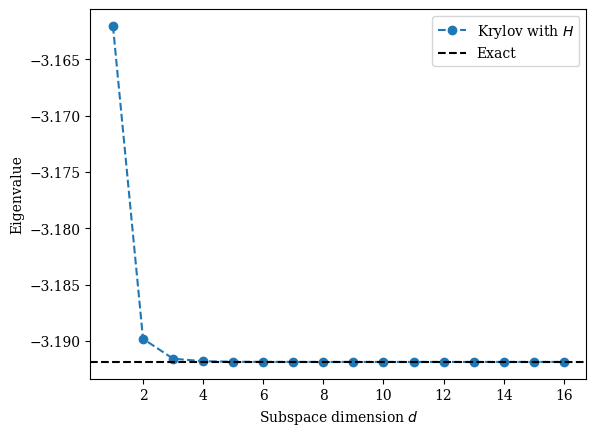

In [14]:
plt.plot(krylov_dvals, krylov_evals, "--o", label="Krylov with $H$")
plt.axhline(energy_exact, ls="--", color="black", label="Exact")
plt.xlabel("Subspace dimension $d$")
plt.ylabel("Eigenvalue")
plt.legend();

### Unitary Krylov

In [15]:
# See Theorem 3.1 of https://arxiv.org/abs/2110.07492.
# dt = np.pi / (evals_exact[-1] - evals_exact[0])
dt = np.pi / mpo.norm()

if problem == "hchain":
    dt *= 5 * natoms  # Empirically found that larger dt works better for H chains.

dt

1.2887527042360303

In [16]:
if nqubits <= 10:
    matrix = mpo.to_dense()
    vec = bvec.to_dense()

    vectors_u = []
    for k in range(-subspace_dimension // 2, subspace_dimension // 2 + 1, 1):
        print(k)
        Uk = sp.sparse.linalg.expm(-1j * matrix * k * dt)  # TODO: Speedup with https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.expm_multiply.html.
        vectors_u.append(Uk @ vec)


    h, s = fill_h_and_s_matrices(vectors_u, matrix, verbose=True)

    krylov_u_dvals = []
    krylov_u_evals = []
    for d in range(1, len(h)):
        try:
            krylov_energy = solve_regularized_gen_eig(h[:d, :d], s[:d, :d], threshold=threshold)
            print(d, krylov_energy)
            krylov_u_dvals.append(d)
            krylov_u_evals.append(krylov_energy)
        except np.linalg.LinAlgError:
            continue

## Trotterized unitary Krylov

In [17]:
def cirq_pauli_sum_to_qiskit_pauli_op(pauli_sum: cirq.PauliSum) -> qiskit.quantum_info.SparsePauliOp:
    """Returns a qiskit.SparsePauliOp representation of the cirq.PauliSum."""
    cirq_pauli_to_str = {cirq.X: "X", cirq.Y: "Y", cirq.Z: "Z"}

    qubits = pauli_sum.qubits
    terms = []
    coeffs = []
    for term in pauli_sum:
        string = ""
        for qubit in qubits:
            if qubit not in term:
                string += "I"
            else:
                string += cirq_pauli_to_str[term[qubit]]
        terms.append(string)
        assert np.isclose(term.coefficient.imag, 0.0, atol=1e-7)
        coeffs.append(term.coefficient.real)
    return qiskit.quantum_info.SparsePauliOp(terms, coeffs)

In [18]:
hamiltonian_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(hamiltonian_cirq)

In [ ]:
ntrotter_values = [1, 2, 4, 8, 16, 32]
trotter_circuits = []
all_krylov_u_trotter_dvals = []
all_krylov_u_trotter_evals = []

for ntrotter in ntrotter_values:
    print("Status: ntrotter =", ntrotter)
    trotter_operation = qiskit.circuit.library.PauliEvolutionGate(
        hamiltonian_qiskit,
        time=dt,
        synthesis=qiskit.synthesis.LieTrotter(reps=ntrotter)
    )
    trotter_circuit = qiskit.QuantumCircuit(nqubits)
    trotter_circuit.append(trotter_operation, trotter_circuit.qubits)
    trotter_circuit = qiskit.transpile(
        trotter_circuit, basis_gates=["u3", "cx"]
    )  # TODO: Compile to a target backend, e.g. IBM Fez.
    print("Trotter circuit gate counts:")
    print(trotter_circuit.count_ops())

    trotter_circuits.append(trotter_circuit)

    forward = trotter_circuit.copy()
    forward_qasm = qiskit.qasm2.dumps(forward)

    reverse = trotter_circuit.inverse().copy()
    reverse_qasm = qiskit.qasm2.dumps(reverse)

    forward_vectors = [bvec]

    for k in range(subspace_dimension // 2):
        print("Forward:", k)
        new = qtn.CircuitMPS.from_openqasm2_str(
            forward_qasm, psi0=forward_vectors[-1], progbar=False, max_bond=max_mps_bond,
        ).psi
        forward_vectors.append(new)
    
    reverse_vectors = [bvec]
    for k in range(subspace_dimension // 2):
        print("Reverse:", k)
        new = qtn.CircuitMPS.from_openqasm2_str(
            reverse_qasm, psi0=reverse_vectors[-1], progbar=False, max_bond=max_mps_bond,
        ).psi
        reverse_vectors.append(new)

    _ = reverse_vectors.pop(0)
    reverse_vectors = list(reversed(reverse_vectors))

    vectors_u_trotter = reverse_vectors + forward_vectors

    h, s = fill_h_and_s_matrices(vectors_u_trotter, mpo, verbose=True)

    krylov_u_trotter_evals = []
    krylov_u_trotter_dvals = []
    for d in range(1, len(h)):
        try:
            krylov_energy = solve_regularized_gen_eig(h[:d, :d], s[:d, :d], threshold=threshold)
            print(f"Krylov {d} energy:", krylov_energy)
            krylov_u_trotter_dvals.append(d)
            krylov_u_trotter_evals.append(krylov_energy)
        except np.linalg.LinAlgError:
            continue
    
    all_krylov_u_trotter_dvals.append(krylov_u_trotter_dvals)
    all_krylov_u_trotter_evals.append(krylov_u_trotter_evals)
    print("\n" * 10)

Status: ntrotter = 1
Trotter circuit gate counts:
OrderedDict([('cx', 1544), ('u3', 1283)])
Forward: 0
Forward: 1
Forward: 2
Forward: 3
Forward: 4
Forward: 5
Forward: 6
Forward: 7
Reverse: 0
Reverse: 1
Reverse: 2
Reverse: 3
Reverse: 4
Reverse: 5
Reverse: 6
Reverse: 7
A_00 A_01 A_02 A_03 A_04 A_05 A_06 A_07 A_08 A_09 A_010 A_011 A_012 A_013 A_014 A_015 A_016 A_11 A_12 A_13 A_14 A_15 A_16 A_17 A_18 A_19 A_110 A_111 A_112 A_113 A_114 A_115 A_116 A_22 A_23 A_24 A_25 A_26 A_27 A_28 A_29 A_210 A_211 A_212 A_213 A_214 A_215 A_216 A_33 A_34 A_35 A_36 A_37 A_38 A_39 A_310 A_311 A_312 A_313 A_314 A_315 A_316 A_44 A_45 A_46 A_47 A_48 A_49 A_410 A_411 A_412 A_413 A_414 A_415 A_416 A_55 A_56 A_57 A_58 A_59 A_510 A_511 A_512 A_513 A_514 A_515 A_516 A_66 A_67 A_68 A_69 A_610 A_611 A_612 A_613 A_614 A_615 A_616 A_77 A_78 A_79 A_710 A_711 A_712 A_713 A_714 A_715 A_716 A_88 A_89 A_810 A_811 A_812 A_813 A_814 A_815 A_816 A_99 A_910 A_911 A_912 A_913 A_914 A_915 A_916 A_1010 A_1011 A_1012 A_1013 A_1014 A_

In [ ]:
cutoff_ind = -1

kwargs = {"alpha": 0.6667, "mec": "black"}

# plt.figure(figsize=(8, 5))

errors_h = np.abs(np.array(krylov_evals) - energy_exact)
plt.plot(krylov_dvals[:cutoff_ind], errors_h[:cutoff_ind], "--s", label="$\mathcal{H}$", **kwargs)

if nqubits <= 10:
    errors_u = np.abs(np.array(krylov_u_evals) - energy_exact)
    plt.plot(krylov_u_dvals[:cutoff_ind], errors_u[:cutoff_ind], "--s", label="$U$", **kwargs)

for ntrotter, krylov_u_trotter_dvals, krylov_u_trotter_evals in zip(ntrotter_values, all_krylov_u_trotter_dvals, all_krylov_u_trotter_evals):
    errors_u_trotter = np.abs(np.array(krylov_u_trotter_evals) - energy_exact)
    plt.plot(krylov_u_trotter_dvals[:cutoff_ind], errors_u_trotter[:cutoff_ind], "--s", label=rf"$U'$ ({ntrotter} Trotter step(s))", **kwargs)

plt.axhline(1e-3, ls="--", color="black", label="Chemical accuracy")

# plt.title(f"{nqubits}-qubit Fermi-Hubbard Hamiltonian\nInitial state overlap with ground state = {round(overlap, 3)}")
plt.xlabel("Subspace dimension $d$")
plt.ylabel("Absolute energy error")

plt.yscale("log")
plt.legend(ncol=2) #bbox_to_anchor=(1.05, 1));
plt.tight_layout()
# plt.savefig(f"krylov_{problem}_nqubits_{nqubits}_overlap_{overlap}_threshold_{threshold}_max_trotter_{max(ntrotter_values)}_dt_{dt}_seed_{seed}.pdf")

In [ ]:
ngates_oneq = []
ngates_twoq = []
depths = []

for circuit in trotter_circuits:
    counts = circuit.count_ops()
    ngates_oneq.append(counts.get("u3"))
    ngates_twoq.append(counts.get("cx"))
    depths.append(circuit.depth())

In [ ]:
plt.plot(ntrotter_values, ngates_oneq, "--o", label="One-qubit gates")
plt.plot(ntrotter_values, ngates_twoq, "--o", label="Two-qubit gates")
plt.plot(ntrotter_values, depths, "--o", label="Circuit depth")

plt.xlabel("Number of Trotter steps")
plt.ylabel("Count")

plt.legend();